## Импортируем библиотеки:

In [2]:
import vk
import folium
from folium.plugins import MarkerCluster
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import geopy.distance
import matplotlib.pyplot as plt
import seaborn as sns
import math
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5) 

## Авторизация ВК:

In [3]:
#ACCESS_TOKEN = "ada1e793ada1e793ada1e793b7adff21c5aada1ada1e793f479065df7fc3e9fc5f7b588"
#session = vk.Session(access_token=ACCESS_TOKEN)
session = vk.AuthSession(app_id='6211158', user_login=' ',
                         user_password=' ')
vkapi = vk.API(session=session)

## Извлекаем места:

In [15]:
#запрос отдает за раз максимум около двух тысяч объектов. Поэтому будем делать поэтапно
place = []
for i in xrange(0,15):
    place.extend( vkapi.places.getById( places=xrange(i*1000+1,(i+1)*1000+1)) )

In [16]:
len(place)

15000

In [17]:
#для Москвы city=1
print vkapi.database.getCitiesById(city_ids=1)[0]['name']

Москва


In [18]:
df = pd.DataFrame(place) #в пандас
print df.shape
df.drop(['icon'], 1, inplace=True) #удаляем ерунду
df_moscow = df.drop(df[df.city != 1].index) #оставляем только Москву
df_moscow.drop(['country','city'], 1, inplace=True)
coord = df_moscow[['latitude', 'longitude']].as_matrix()
pop= df_moscow['title'].as_matrix()


def distFromCenter(i):
    moscow_center = [55.752605, 37.621381]
    return geopy.distance.vincenty(coord[i], moscow_center).km

#добавляем столбец с расстоянием до центра
dist = np.zeros(df_moscow.shape[0])
for i in xrange(df_moscow.shape[0]):
    dist[i] = distFromCenter(i)
df_moscow['dist'] = dist
df_moscow.head()

(15000, 12)


,address,checkins,created,latitude,longitude,pid,title,type,updated,dist
0,Мячковский б-р 3а,441,1280741941,55.657941,37.751574,1,Baila Baila,4,1.507325e+09,13.344408
9,Гурьянова 31,14,1280741941,55.684858,37.718300,10,Salvador Dali,4,1.498625e+09,9.694928
14,2-я Брестская 6,5,1280741941,55.770968,37.591562,15,Моспроект,4,1.444137e+09,2.772006
19,Лубянский пр. 25К1,0,1280741941,55.757116,37.631460,20,Дом Кукера,4,1.344699e+09,0.807913
21,Новослободская 26,2,1280741941,55.783104,37.598025,22,Хроника-бар,4,1.398173e+09,3.698614


In [19]:
#получаем список типов мест
placesTypes = vkapi.places.getTypes(lang=13)
places = []
for i in xrange(21):
    places.append(placesTypes[i]['title'])
    print i+1, ":", places[i]


1 : Home
2 : Work
3 : Restaurant
4 : Club
5 : Movie Theater
6 : Bar
7 : Entertainment
8 : Store
9 : Airport
10 : Train Station
11 : Hotel
12 : Café
13 : Fast Food Restaurant
14 : Pizzeria
15 : Swimming Pool
16 : Gym
17 : Educational Institution
18 : Museum
19 : Theater
20 : Park
21 : Other


## Объекты на карте:

In [21]:
moscow_center = [55.752605, 37.621381]
moscow = folium.Map(location=moscow_center, zoom_start=11, control_scale=True)
marker_cluster = MarkerCluster(locations=coord[:500,:], popups=pop[:500])
marker_cluster.add_to(moscow)
moscow

## Расстояние до центра:

### Число объектов:

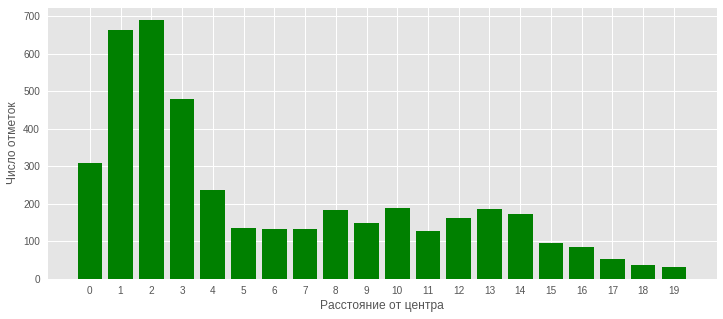

In [35]:
circle = np.zeros(20)
for k in xrange(20):
    for i in xrange(df_moscow.shape[0]):
        if (distFromCenter(i) > k) and (distFromCenter(i) < k+1):
            circle[k] = circle[k] + 1

plt.bar( xrange(20), circle, color='green')
plt.xticks(xrange(20) ,xrange(20), rotation=0 )
plt.xlabel(u"Расстояние от центра")
plt.ylabel(u"Число отметок")
plt.show()

### Плотность

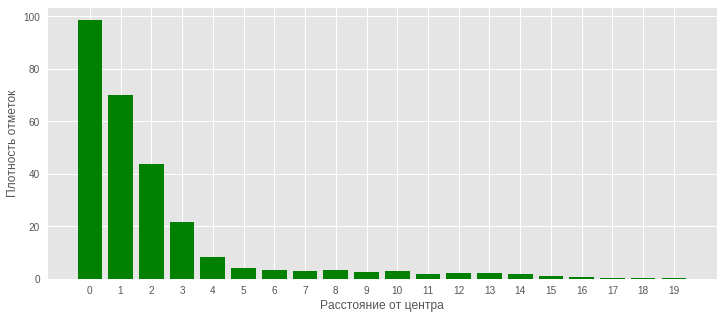

In [36]:
dense = np.zeros(20)
for k in xrange(20):
    dense[k] = circle[k] / (math.pi*(k+1)**2 - math.pi*k**2)

plt.bar( xrange(20), dense, color='green')
plt.xticks(xrange(20) ,xrange(20), rotation=0 )
plt.xlabel(u"Расстояние от центра")
plt.ylabel(u"Плотность отметок")
plt.show()

## Распределение чекинов:

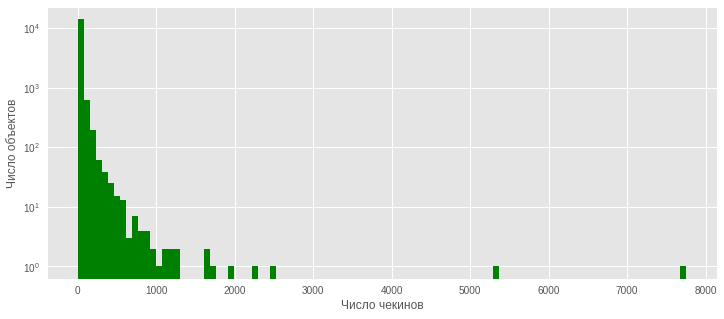

In [38]:
plt.hist(df.checkins, bins=101, color='green')
plt.yscale('log')
plt.xlabel(u'Число чекинов')
plt.ylabel(u'Число объектов')
plt.show()

## Типы объектов:

Restaurant : 10936
Club : 1626
Home : 1242
Movie Theater : 512
Train Station : 299
Airport : 183
Entertainment : 90
Work : 90
Store : 13
Bar : 9


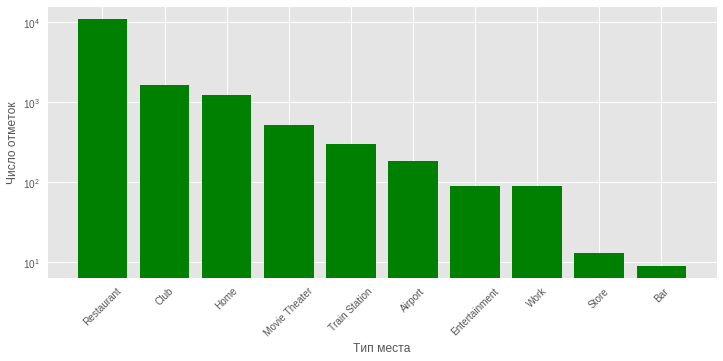

In [39]:
numberOfTypes = df['type'].value_counts()
numberOfTypesIndex = pd.DataFrame(numberOfTypes).index.values-1
numberOfTypesIndex = numberOfTypesIndex.astype(int)
numberOfTypes = numberOfTypes.values

placesSort = []
for i in xrange(len(numberOfTypes)):
    placesSort.append(places[numberOfTypesIndex[i]])

for i in xrange(10):
    print places[numberOfTypesIndex[i]], ":", numberOfTypes[i]

plt.bar( xrange(len(numberOfTypes)), numberOfTypes, color='green')
plt.xticks( xrange(10) , placesSort, rotation=45 )
plt.yscale('log')
plt.xlabel(u"Тип места")
plt.ylabel(u"Число отметок")
plt.show()


## Box-plot:

In [40]:
#число чекинов по типу места
checkIns = []
for i in xrange(0,11):
    checkIns.append(  df.drop(df[df.type !=i].index).checkins.as_matrix() )


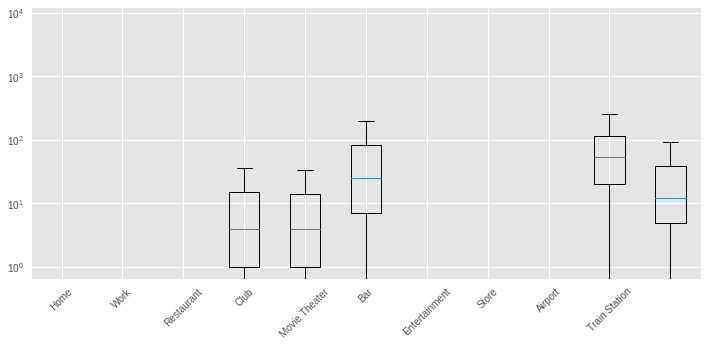

In [41]:
plt.figure()
plt.boxplot(checkIns)
plt.yscale('log')
plt.xticks( xrange(1,11),places, rotation=45 )
#print i, ":", placesSort[i]
plt.show()

## Время добавления:

In [42]:
from datetime import datetime

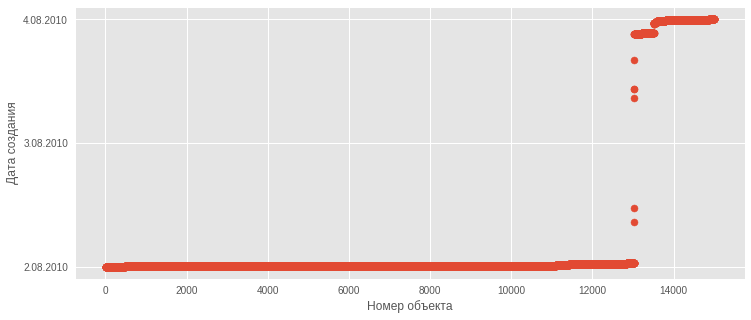

In [69]:
plt.scatter(df.pid, df.created)
#plt.yticks( xrange(3) , placesSort, rotation=45 )
plt.yticks( [1280741941,1280804767 , 1280867594], [u"2.08.2010",u"3.08.2010",u"4.08.2010"])
plt.xlabel(u"Номер объекта")
plt.ylabel(u"Дата создания")
plt.show()

In [44]:
datetime.fromtimestamp(df.created[0])

datetime.datetime(2010, 8, 2, 13, 39, 1)

In [45]:
datetime.fromtimestamp(df.created[14999])

datetime.datetime(2010, 8, 4, 0, 33, 14)

Все объекты были созданы в августе 2010 года